# A river flood case study.

In [1]:
## J. Rohmer (BRGM) j.rohmer@brgm.fr
## Flood case adapted from Baudin, M., Dutfoy, A., Iooss, B., & Popelin, A. L. (2017). 
## Openturns: An industrial software for uncertainty quantification in simulation. 
## In Handbook of uncertainty quantification (pp. 2001-2038). Springer, Cham.

# Librairies

In [ ]:
install.packages("DiceKriging")#Kriging Metamodelling
install.packages("sensitivity") # Sobol' indices and (truncated) Gumbel law and truncated Normal law
install.packages("fitdistrplus")#fitting probability laws
install.packages("triangle") # Triangular probability law
install.packages("ggplot2") # nice plots
install.packages("GGally") #nice matrix of scatterplots
install.packages("edv") #nice matrix of scatterplots

In [2]:
library(sensitivity) # Sobol' indices and (truncated) Gumbel law and truncated Normal law
library(triangle) # Triangular probability law
library(ggplot2) # nice plots
library(GGally) #matrix of scatterplots
library(DiceKriging)#Kriging Metamodelling
library(fitdistrplus)#fitting probability laws
library(evd)#extreme value distribution

rm(list=ls()) ## remove all
set.seed(12345) ## set seed

Warning message:
"package 'sensitivity' was built under R version 3.6.3"Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr
Warning message:
"package 'triangle' was built under R version 3.6.2"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Warning message:
"package 'fitdistrplus' was built under R version 3.6.2"Loading required package: MASS
Loading required package: survival
Loading required package: npsurv
Loading required package: lsei

Attaching package: 'npsurv'

The following object is masked from 'package:DiceKriging':

    km



# STEP 1: Problem definition
Our objective is twofold: 1. (C) Comply with a given threshold defined in terms of overflow; 2. (U) Understand hwo the input uncertainties affect the variability of the overflow.

We consider a simplified first model simulating flooding events.
The model has $8$ input random variables, viewed as random variables:

* $X_{1} = Q$, Maximal annual flowrate (m$^3$/s), Gumbel ${\mathcal G}(1013, 558)$ truncated on $[500 , 3000 ]$
* $X_{2}=K_s$, Strickler coefficient, Normal ${\mathcal N}(30, 8^2)$ truncated on $[15 , +\infty [$
* $X_{3} = Z_v$, River downstream level (m), Triangular ${\mathcal T}(49, 51)$ 
* $X_{4} = Z_m$, River upstream level (m), Triangular  ${\mathcal T}(54, 56)$
* $X_{5} = H_d$, Dyke height (m),  Uniform ${\mathcal U}[7, 9]$ 
* $X_{6} = C_b$, Bank level (m), Triangular ${\mathcal T}(55, 56)$
* $X_{7} = L$, River stretch (m), Triangular ${\mathcal T}(4990, 5010)$
* $X_{8} = B$, River width (m), Triangular ${\mathcal T}(295, 305)$

We consider the maximal annual overflow $S$ (in meters), obtained from simplified hydro-dynamical equations of Saint-Venant:
\begin{equation}
S = \left(\frac{Q}{BK_s \sqrt{\frac{Z_m-Z_v}{L} }} \right)^{0.6} + Z_v - H_d - C_b \,.
\end{equation}

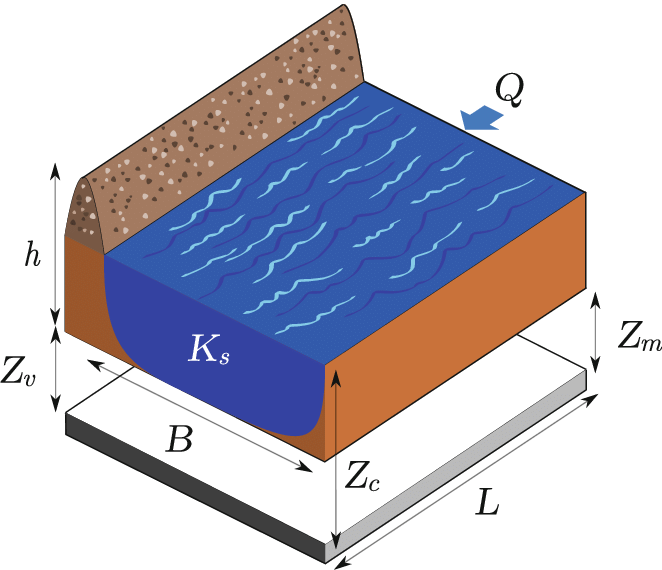

In [3]:
# Input names
floodInputNames <- c("Q", "Ks", "Zv", "Zm", "Hd", "Cb", "L", "B")
floodOutputNames <- c("Overflow")

# Flood impact model
flood <- function(X){ 

    mat <- as.matrix(X, ncol = 8)
    output <- rep(NA, nrow(mat))
    
    for (i in 1:nrow(mat)){
        H <- (mat[i, 1] / (mat[i, 2] * mat[i, 8] * sqrt((mat[i, 4] - mat[i, 3]) / mat[i, 7])))^0.6
        S <- mat[i, 3] + H - mat[i, 5] - mat[i, 6] 
        output[i] <- S
    }
    
    return(output)

}

# STEP 2: Uncertainty representation

## We will fit a probability law to $K_s$ based on 30 calibrated values.

In [4]:
## load calibrated values
Ks = read.table("Ks_calibrated_1.txt",header = FALSE)
Ks = as.vector(t(Ks))

**QUESTION** Plot the Cullen and Frey graph. What probability law does it suggest? Note that we know that the variable is not bounded on an interval.

summary statistics
------
min:  15   max:  48.6 
median:  29.7 
mean:  29.76667 
estimated sd:  7.459793 
estimated skewness:  0.361742 
estimated kurtosis:  3.264505 

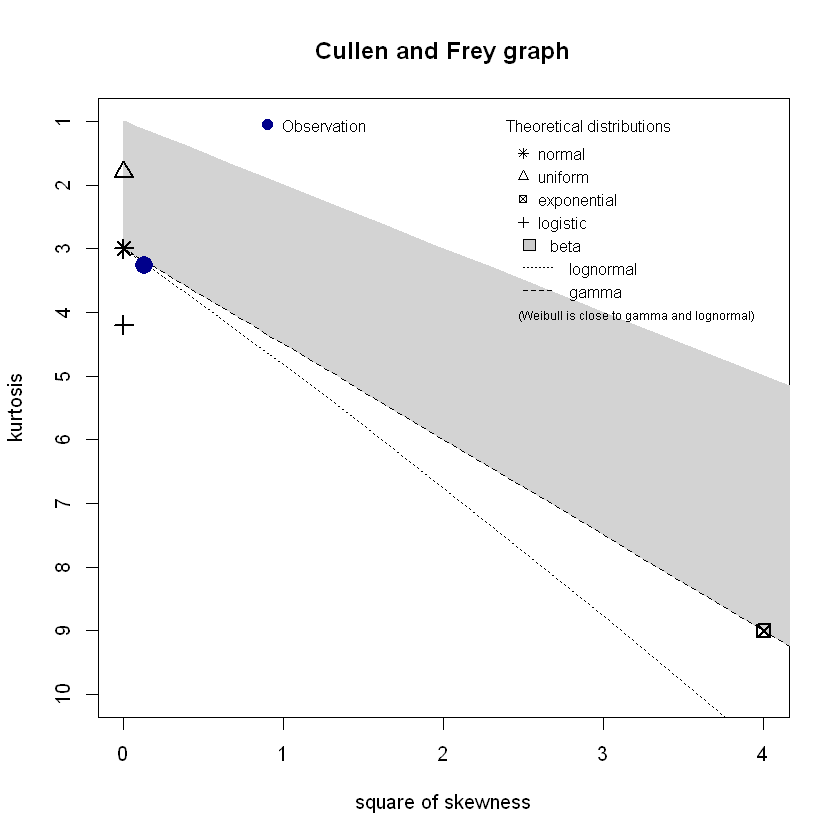

In [5]:
descdist(Ks)

**QUESTION** Fit the first plausible probability law and check the quality using some graphics. What do you see? Hints: Normal = "norm"; Lognormal = "lnorm"; Uniform = "unif"; Exponential = "exp"; Weibull = "weibull", etc.

In [ ]:
law1 = "norm"
fit1  = fitdist(Ks,law1)

par(mfrow = c(2,2))
denscomp(fit1)
cdfcomp(fit1)
qqcomp(fit1)
ppcomp(fit1)

**QUESTION** Do the same for the second plausible law. What do you see?

In [ ]:
law2 = # COMPLETE #
fit2  = # COMPLETE #

par(mfrow = c(2,2))
# COMPLETE #
# COMPLETE #
# COMPLETE #
# COMPLETE #

**QUESTION** Do the same for the third plausible law.

In [ ]:
# COMPLETE #

**QUESTION** Estimate the Goodness-of-fit statistics and criteria. The aim is to minimize them. What do you see?

In [ ]:
gofstat(list(fit1,fit2,fit3))

**QUESTION** Do the same analysis by loading the file named "Ks_calibrated_2.txt".

# STEP 3: Uncertainty propagation

## Define the functions for sampling and probability estimates

In [10]:
# Function for flood model inputs random sampling
floodSample <- function(size){
    X <- matrix(NA, size, 8)
    X[, 1] <- rgumbel.trunc(size, loc = 1013, scale = 558, min = 500, max = 3000)
    X[, 2] <- rnorm.trunc(size, mean = 30, sd = 10, min = 15)
    X[, 3] <- rtriangle(size, a = 49, b = 51)
    X[, 4] <- rtriangle(size, a = 54, b = 56)
    X[, 5] <- runif(size, min = 7, max = 9)
    X[, 6] <- rtriangle(size, a = 55, b = 56)
    X[, 7] <- rtriangle(size, a = 4990, b = 5010)
    X[, 8] <- rtriangle(size, a = 295, b = 305)
    return(X)
}

# 2nd Function for flood model inputs random sampling: remove of truncation for 1st and 2nd inputs
floodSample2 <- function(size){
    X <- matrix(NA, size, 8)
    X[, 1] <- rgumbel.trunc(size, loc = 1013, scale = 558, min = 0)# modification
    X[, 2] <- rnorm.trunc(size, mean = 30, sd = 8, min = 0)#modification
    X[, 3] <- rtriangle(size, a = 49, b = 51)
    X[, 4] <- rtriangle(size, a = 54, b = 56)
    X[, 5] <- runif(size, min = 7, max = 9)
    X[, 6] <- rtriangle(size, a = 55, b = 56)
    X[, 7] <- rtriangle(size, a = 4990, b = 5010)
    X[, 8] <- rtriangle(size, a = 295, b = 305)
    return(X)
}

# Function to compute the probability of exceedance given threshold THR
floodProb <- function(Y,THR){
    ## Define the event of interest A
    A = (Y <= THR)
    ## Tester si A est vrai avec la fonction which() 
    A.vrai = which(A==TRUE)
    ## Calculer la probabilité
    P =  1 - length(A.vrai) / length(Y)
return(P)
}

# Function to study probability estimate's convergence
ProbConv <- function(Y,NN,THR){
    P <- C1 <- C2 <- NULL
    c <- 0
    for (i in NN){

        c <- c + 1 
        #### CALCULER la probabilite detre >= 1
        P[c]<-floodProb(Y[1:i],THR)

        cov = sqrt((1 - P[c])/(i * P[c])) ###erreur Monte-Carlo
        C1[c]<-P[c]*(1 - 2 * cov) ### borne inf a 95% 
        C2[c]<-P[c]*(1 + 2 * cov) ### borne sup a 95%
        
    }
return(list(P=P,lower95=C1,upper95=C2))
}

**QUESTION** Run the code to visualize 100 randomly generated input vectors. Is the plot in agreement with the assumptions?

In [ ]:
N = 100
X = floodSample(N)
df = data.frame(X)
names(df) = floodInputNames
ggpairs(df)

## Estimate the probability of interest using a "classical" Monte-Carlo sampling scheme.

**DEFINE** The number denoted $THR$ the threshold above which the risk event occurs. Set up $THR$ at -10m.

In [ ]:
THR = # COMPLETE #

**DEFINE** The number denoted 𝑁 is the number of Monte-Carlo random samples. Set up $N$ at 1000.

In [ ]:
N = # COMPLETE #

In [ ]:
X = floodSample(N) ## sampling the inputs
Y = flood(X) ## estimate the variable of interest
##### PLOT 
par(mfrow=c(1,2))
hist(Y) ## Histogramm
abline(v= THR,lwd=4,col=2)
plot(ecdf(Y)) ## plot empirical CDF
abline(v = THR, lwd=4, col=2)

The probability of exceeding the threshold denoted $THR$ given $N$ random samples is

In [ ]:
print(P <- floodProb(Y,THR))

**QUESTION** Now compute $P$ for $N$ = 10,000. What do you see?

## Analyse the convergence for $N$ up to 250,000 samples.

In [ ]:
N <- 250e3
X<- floodSample(N)
Y <- flood(X)
NN <- c(500, seq(1000,N,by=1000)) 
Cvg <- ProbConv(Y,NN,THR)
plot(NN,Cvg$P,
     ty="l",lwd=4,col=2,log="x",
     ylim=c(min(Cvg$lower95)*0.9,max(Cvg$upper95)*1.1),
     xlab="N samples",ylab="Probability of interest")
lines(NN,Cvg$lower95,col=2)
lines(NN,Cvg$upper95,col=2)

**QUESTION** What is the value of $N$ above which you consider that the probability of interest has converged? What is the error on this estimate?

**QUESTION** Do the same analysis by considering $THR$ = -9m.

## STEP 4: Sensivity analysis

### Scatter-plot analysis & visualization

As a first sensitivity diagnostic, we plot 1,000 randomly generated output versus the corresponding input variables.

In [ ]:
N <- 1000
X <- floodSample(N)
Y <- flood(X)
par(mfrow = c(2, 4))
options(repr.plot.width = 15, repr.plot.height = 6)
for (i in 1:8){
    plot(Y ~ X[, i], xlab = floodInputNames[i], ylab = floodOutputNames, 
         pch = 19, col = "grey", cex = 0.5, cex.lab = 1.5)
    ss <- smooth.spline(x = X[, i], y = Y)
    lines(ss, col = "blue", lwd = 3)
}

**QUESTION** Which input variables seem influential/inactive?
What represents the blue line?

## Computation of Sobol indices

**DEFINE** The number denoted $N$ is the number of Monte-Carlo random samples. Set up $N$ at 1,000.

In [ ]:
N = # COMPLETE #

**QUESTION** How many model runs $n$ do we need? (recall the number of inputs is d=8)

In [ ]:
n = # COMPLETE #
print(n)

In [ ]:
# we use a pick-freeze formula named "Jansen", which requires two matrix random samples
X1 <- floodSample(N)
X2 <- floodSample(N)
X1 <- data.frame(X1); names(X1) <- floodInputNames
X2 <- data.frame(X2); names(X2) <- floodInputNames

# sensitivity analysis
x <- soboljansen(model = flood, X1, X2, nboot = 100)
totalIndex <- x$T$original; names(totalIndex) <- floodInputNames
sobolIndex <- x$S$original; names(sobolIndex) <- floodInputNames

# plot
ggplot(x)

# print the total effects
print("Total effects")
totalIndex

# print the main effects
print("Main effects")
sobolIndex 

**QUESTION** Interpret the result. Is it consistent with the output~input plots? What other information can you get now? About the most important inputs? About the inputs of negligible influence? What are the interactions within the flood model? 

**QUESTION** Is the convergence satisfactory? Increase $N$ to 10,000. What do you see?

# Metamodelling
In this section, we do not use the flood impact assessment model but we learn a kriging-based metamodel and perform the sensitivity analysis with it.

**QUESTION** randomly generate two datasets using floodSample(.) for: 1. the training of the metamodel (denoted $S_{BA}$); 2. for the validation (denoted $S_{BT}$). The size of $S_{BA}$ is $N_{BA}$ = 15 and the one of $S_{BT}$ is $S_{BT}$ = 100

In [ ]:
#### TRAINING AND VALIDATION DATASET ####
d = 8  ## Dimension of the inputs' space
N_BA = # COMPLETE #
N_BT = # COMPLETE #
S_BA = # COMPLETE #
S_BT = # COMPLETE #

Y_BA = flood(S_BA) ## evaluate the value of the output
Y_BT = flood(S_BT) ## evaluate the value of the output

In [ ]:
#### LEARN the METAMODEL ####
metamodel = DiceKriging::km(formula=~1, design=S_BA, response=Y_BA)  # construction of the metamodel with function km(.)

In [ ]:
## Performance analysis using the indicator Q2
## y: true value
## yhat: prediction
Q2 <- function(y,yhat)
  1-mean((y-yhat)^2)/var(y)

**QUESTION** Analyse the performance using Q2 calculated within a Leave-One-Out Cross-validation approahch and plot the prediction versus the true value.

In [ ]:
## Prediction within the cross validation procedure 
prediction_LOO = leaveOneOut.km(metamodel,"UK")$mean

## Evaluate Q2
Q2_LOO = # COMPLETE #
print(paste('Q2 sur Base de test :',round(Q2_LOO,2)))

## plot the scatterplot true value versus prediction using the plot(.) function
# COMPLETE #
abline(0,1) # plot the 1:1 line

**QUESTION** Do the same but with the independent validation dataset. Compare the performance using LOOCV and an independent validation dataset.

In [ ]:
## Performance analysis (indicator Q2) using the validation dataset
prediction = predict(metamodel, newdata=S_BT, type='UK')$mean  ## Prediction
Q2_BT = # COMPLETE #
print(paste('Q2 sur Base de test :',round(Q2_BT,2)))

## plot the scatterplot ttrue value versus prediction
# COMPLETE #
abline(0,1)

**QUESTION** Perform the sensitivity analysis (three following chunks of codes) and compare with the results using the "true" model.

In [ ]:
#### Estimation des indices des cartes d'indices de Sobol du 1er ordre et totaux ####
# Creation de la fonction qui calcule les predictions du métamodèle, 
# pour laquelle on calcule les indices de Sobol
f <- function(x) 
  predict(metamodel,x,type='UK',checkNames=FALSE)$mean

# we use a pick-freeze formula (Sobol Jansen), which requires two samples
X1 <- floodSample(N)
X2 <- floodSample(N)
X1 <- data.frame(X1); names(X1) <- floodInputNames
X2 <- data.frame(X2); names(X2) <- floodInputNames

# sensitivity analysis
x <- soboljansen(model = f, X1, X2, nboot = 100)
totalIndex.meta <- x$T$original; names(totalIndex) <- floodInputNames
sobolIndex.meta <- x$S$original; names(sobolIndex) <- floodInputNames

In [ ]:
barplot(t(cbind(sobolIndex,sobolIndex.meta)),beside=T,ylab="main effect")
legend("topright",legend=c("Main effect wo Flood model","Main effect w Metamodel"),col=c("black","grey"),pch=15)

In [ ]:
barplot(t(cbind(totalIndex,totalIndex.meta)),beside=T,ylab="main effect")
legend("topright",legend=c("Total effect wo Flood model","Total effect w Metamodel"),col=c("black","grey"),pch=15)

**QUESTION** do the same analysis with 10 random samples to train the metamodel. What do you see?

**QUESTION** do the same analysis with 50 random samples to train the metamodel. What do you see?

# Your turn
Do the analysis STEPs2, 3 and Metamodelling using floodSample2(.) function.